<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Customer Segmentation with K-means Clustering and Data Preparation Piplelines
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>

<b style = 'font-size:20px;font-family:Arial;'>Leverage native Vantage processing for efficient and highly scalable data preparation, model training, and evaluation workflows</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>K-means clustering is one of the most popular <b>unsupervised</b> machine learning algorithms.  Essentially, the algorithm seeks to group similar data points together by minimizing the average ("means" in K-means) distance for all data points from each cluster's center (centroid).</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Define the number of clusters (k)</li>
                <br>
                <li>The algorithm chooses random points as centroids</li>
                <br>
                <li>Each iteration attempts to optimize the centroid locations</li>
                <br>
                <li>Iterations end once the distances have stabilized or the max iteration count is reached</li>
            </ol>
        </td>
        <td><img src = 'images/K-means_convergence.gif' width = '250'></td>
    </tr>
</table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>One limitation of this algorithm is that it only accepts numeric data as feature input (categorical clustering can be performed using K-modes algorithm).  Typically, data engineers or data scientists will perform multiple <b>serial</b> steps to prepare a numeric-only data set that can be passed to the K-means algorithm.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage provides native "Fit and Transform" functions to assist in data preparation and transformation at scale.  To aid in efficiency and operationalization, Vantage provides a bulk <b>Column Transformer</b> function which can take multiple transformation directives at the same time, and act on the whole data set at once.  This allows for both process and code simplification, allowing more streamlined and robust operational deployment.</p> 

<img src = 'Flow_Diagram_KMeans.png' width = 100%>


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The data for this demonstration is based on online purchase history data set, which can be found <a href = 'https://www.kaggle.com/code/hellbuoy/online-retail-k-means-hierarchical-clustering/data'>here</a>.  The goal is to segment the customers by purchase volume and value.  Steps are as follow:</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Analyze the raw data, split a testing set</li>
                <br>
                <li>Engineer numeric features</li>
                <br>
                <li>Build the K-means model</li>
                <br>
                <li>Apply in-line transformation to the testing set</li>
                <br>
                <li>Make Predictions and evaluate model accuracy</li>
            </ol>
        </td>
        <td><img src = 'images/clustering_img.png' width = '250'></td>
    </tr>
</table>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>You will be prompted to provide the password. Enter your password, press Enter, then use down arrow to go to next cell.</p>

In [1]:
%connect local, hidewarnings=true

Password: ··················


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


In [ ]:
--%disconnect local, hidewarnings=true

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>

In [2]:
SET query_band='DEMO=K-Means_Clustering_and_ML_model_SQL.ipynb;' UPDATE FOR SESSION;

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage. In this demo since we are using Temporal table we will be creating databases and tables in local storage and use them in the notebook. Please execute the procedure in the next cell.</p>

In [ ]:
-- call get_data('DEMO_Retail_cloud');    -- takes about 4 minutes
call get_data('DEMO_Retail_local');     -- takes about 7 minutes

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – if you want to see status of databases/tables created and space used.</p>

In [ ]:
call space_report();  -- optional, takes about 10 seconds

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Access data in Vantage  </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>For this demo, data is already resident in Object Storage which we are accessing via ReadNOS, create a reference to the table, and sample the contents using the get_data procedure used above.  Data could just as easily reside in permanent tables, another RDBMS, or another Vantage system.</p>

In [3]:
SELECT TOP 5 * FROM DEMO_Retail.UK_Retail_Data;

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,556883,23209,LUNCH BAG DOILEY PATTERN,10,2011-06-15 12:24:00.000000,1.65,13343,United Kingdom
2,556883,C2,CARRIAGE,1,2011-06-15 12:24:00.000000,50,13343,United Kingdom
3,556883,22430,ENAMEL WATERING CAN CREAM,4,2011-06-15 12:24:00.000000,4.95,13343,United Kingdom
4,556883,23118,PARISIENNE JEWELLERY DRAWER,2,2011-06-15 12:24:00.000000,7.5,13343,United Kingdom
5,569877,90210C,nan,-10,2011-06-10 15:09:00.000000,0,NaN,United Kingdom


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Data Preparation</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we will inspect the original data set, and perform various preparation tasks.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Inspect the rows of the table</li>
    <li>Inspect the column metadata using <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnSummary&content-lang=en-US'>TD_ColumnSummary</a></li>
    <li>Split off a testing data set to be used in evaluation</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>2.1 View Column information</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><a href = 'https://docs.teradata.com/search/all?query=TD_ColumnSummary&content-lang=en-US'>TD_ColumnSummary</a> provides more details on column values and ranges</p>

In [4]:
SELECT * FROM TD_ColumnSummary(
    ON DEMO_Retail.UK_Retail_Data as inputtable
    USING
        targetcolumns('[0:7]')
) as dt;

,ColumnName,Datatype,NonNullCount,NullCount,BlankCount,ZeroCount,PositiveCount,NegativeCount,NullPercentage,NonNullPercentage
1,StockCode,VARCHAR(10) CHARACTER SET UNICODE,536641,0,0,,,,0,100
2,InvoiceDate,TIMESTAMP(6),536641,0,,,,,0,100
3,InvoiceNo,VARCHAR(10) CHARACTER SET UNICODE,536641,0,0,,,,0,100
4,Description,VARCHAR(40) CHARACTER SET UNICODE,536641,0,0,,,,0,100
5,Country,VARCHAR(25) CHARACTER SET UNICODE,536641,0,0,,,,0,100
6,CustomerID,FLOAT,401604,0,,0,401604,0,0,100
7,Quantity,BIGINT,536641,0,,0,526054,10587,0,100
8,UnitPrice,FLOAT,536641,0,,2510,534129,2,0,100


<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>2.2 Create a Testing data set</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From our sample data we are selecting some "Customer ID" values for testing later.</p>

In [5]:
REPLACE VIEW UK_Retail_Test_V as (
    SELECT * FROM DEMO_Retail.UK_Retail_Data 
    WHERE CustomerID IN ('17307', '12503', '18268', '12908', '13693')
);

Success: 9 rows affected

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Feature Engineering</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage provides many inDb feature engineering functions, in this section we will see how to prepare the data set for model training.  We will use standard SQL and various "Fit" functions to create input for the <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function to take as input in order to execute a bulk transformation.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Create a per-customer grouping of data</li>
    <li>Create Fit Tables
        <ul><li>Remove Outliers</li>
            <li>Impute Missing Values</li>
            <li>Create New Numeric Features</li>
            <li>Rescale the Data Set</li>
        </ul></li>
    <li>Call the final Transformation function</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>3.1 Create a per-customer table</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Simple GROUP BY, exclude the testing IDs.<br> Note there are 4367 unique customers in this training set.</p>

In [6]:
REPLACE VIEW Customer_ID_Group_V AS (
    SELECT CustomerID,
        SUM(quantity) as TotalQuantity , 
        SUM(UnitPrice) as TotalPrice, 
        COUNT(DISTINCT(StockCode)) as TotalItems 
    FROM DEMO_Retail.UK_Retail_Data
    WHERE CustomerID NOT IN ('17307', '12503', '18268', '12908', '13693')
    GROUP BY CustomerID
);

Success: 5 rows affected

In [7]:
SELECT COUNT(*) FROM Customer_ID_Group_V;

,Count(*)
1,4368


In [8]:
SELECT TOP 10 * FROM Customer_ID_Group_V;

,CustomerID,TotalQuantity,TotalPrice,TotalItems
1,17614,235,218.66000000000005,97
2,13500,585,238.26000000000002,60
3,12649,574,86.91,30
4,16168,1888,329.17,57
5,14680,12474,776.3099999999998,83
6,12957,2531,691.2299999999999,208
7,14288,187,60.849999999999994,16
8,16830,264,48.99,23
9,14090,72,1.06,1
10,12910,1692,156.95999999999998,48


<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>3.2 Create Fit Tables</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Vantage <a href = 'https://docs.teradata.com/search/all?query=Feature+Engineering+Transform+Functions&content-lang=en-US'>Feature Engineering Transform Functions</a> Use a "Fit and Transform" approach to make processing more modular and efficient.  "Fit tables" can be used as input to either individual Transform functions, or passed to a single <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function.</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Fit outlier removal using <a href = 'https://docs.teradata.com/search/all?query=TD_OutlierFilterFit&content-lang=en-US'>TD_OutlierFilterFit</a></li>
    <li>Fit a simple imputer to replace missing values using <a href = 'https://docs.teradata.com/search/all?query=TD_SimpleImputeFit&content-lang=en-US'>TD_SimpleImputeFit</a></li>
    <li>Fit column calculations to create new features using <a href = 'https://docs.teradata.com/search/all?query=TD_NonLinearCombineFit&content-lang=en-US'>TD_NonLinearCombineFit</a></li>
    <li>Call <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> to execute the transformations (to allow for Scaling)</li>
    <li>Rescale the data using <a href = 'https://docs.teradata.com/search/all?query=TD_ScaleFit&content-lang=en-US'>TD_ScaleFit/Transform</a></li>
            </ul></td>
        <td><img src = 'images/fit_transform.png' width = '300'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_OutlierFilterFit</b> function calculates the lower_percentile, upper_percentile, count of rows and median for the specified input table columns. The calculated values for each column help the
    <b>TD_OutlierFilterTransform</b> function detect outliers in the input table.

In [9]:
-- Remove Outliers
-- Trim below 3rd, and above 97th percentile

CREATE MULTISET VOLATILE TABLE outlierFit_CS as (
    SELECT * from TD_OutlierFilterFit(
        ON Customer_ID_Group_V as inputTable
        USING
        TargetColumns('TotalQuantity','TotalPrice')
        LowerPercentile(0.03)
        UpperPercentile(0.97)
        OutlierMethod('Percentile')
        PercentileMethod('PercentileCont')
        ReplacementValue('Median')
    )as dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

In [10]:
SELECT * FROM outlierFit_CS;

,TD_OUTLIERMETHOD_OFTFIT,TD_IQRMULTIPLIER_OFTFIT,TD_REMOVETAIL_OFTFIT,TD_REPLACEMENTVALUE_OFTFIT,TD_MINTHRESHOLD_OFTFIT,TD_MAXTHRESHOLD_OFTFIT,TD_ATTRIBUTEVALUE_OFTFIT,TD_COUNTVALUE_OFTFIT,TD_MEDIANVALUE_OFTFIT,TD_LOWERPERCENTILE_OFTFIT,TD_UPPERPERCENTILE_OFTFIT
1,PERCENTILE,1.5,BOTH,MEDIAN,0.03,0.97,TotalQuantity,4368,365,24,4822.729999999994
2,PERCENTILE,1.5,BOTH,MEDIAN,0.03,0.97,TotalPrice,4368,129.08500000000004,6.720999999999999,1292.1290999999997


<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_SimpleImputeFit </b>will output a table with the values that will be used to substitute the missing values<br>
    <b>TD_SimpleImputeTransform</b> will return the input data set with the missing values filled in.

In [11]:
-- Impute Missing Values
-- Replace any missing CustomerID with a specific value

CREATE MULTISET VOLATILE TABLE ImputeFit_CS AS (
    SELECT * FROM TD_SimpleImputeFit(
        ON Customer_ID_Group_V AS InputTable
        USING
        ColsForLiterals('CustomerID')
        Literals('19000')                                        
    ) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

In [12]:
SELECT * FROM ImputeFit_CS;

,TD_INDEX_SIMFIT,TD_TARGETCOLUMN_SIMFIT,TD_NUM_COLVAL_SIMFIT,TD_STR_COLVAL_SIMFIT,TD_ISNUMERIC_SIMFIT
1,0,CustomerID,19000,,1


<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_NonLinearCombineFit</b> function returns the target columns and a specified formula which uses the non-linear combination of existing features.


In [13]:
-- Create a new column by multiplying quantity and price

SELECT * FROM TD_NonLinearCombineFit (
    ON Customer_ID_Group_V as InputTable
    OUT VOLATILE TABLE OutputTable (NonLinearCombineFit_CS_TotalSales)
    USING
        TargetColumns ('TotalQuantity','TotalPrice')
        Formula ('Y = X1*X0')
        ResultColumn ('TotalSales')
) AS dt;

Success: 0 rows affected

,TotalSales,TotalQuantity,TotalPrice
1,Y = X1*X0,,


In [14]:
SELECT * FROM NonLinearCombineFit_CS_TotalSales;

,TotalSales,TotalQuantity,TotalPrice
1,Y = X1*X0,,


In [15]:
-- Create another new column by diving the total sales by the number of unique items

SELECT * FROM TD_NonLinearCombineFit (
   ON Customer_ID_Group_V AS InputTable
   OUT VOLATILE TABLE OutputTable (NonLinearCombineFit_CS_SalesPerItem)
   USING
   TargetColumns ('TotalQuantity','TotalPrice','TotalItems')
   Formula ('Y = (X0*X1)/X2')
   ResultColumn ('SalesPerItem')
) AS dt;

Success: 0 rows affected

,SalesPerItem,TotalQuantity,TotalPrice,TotalItems
1,Y = (X0*X1)/X2,,,


In [16]:
SELECT * FROM NonLinearCombineFit_CS_SalesPerItem;

,SalesPerItem,TotalQuantity,TotalPrice,TotalItems
1,Y = (X0*X1)/X2,,,0


<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>The TD_ColumnTransformer</b> function transforms the entire dataset in a single operation. You only need to provide the FIT tables to the function, and the function runs all transformations that you require in a
single operation. Running all the it table transformations together in one-go gives approx. 30% performance improvement over running each transformation sequentially.</p>

In [17]:
-- Execute ColumnTransformer to build the data set

CREATE MULTISET VOLATILE TABLE Transformed_Customer_ID_Group_VT AS (
    SELECT * from TD_ColumnTransformer(
        ON Customer_ID_Group_V AS InputTable
        
        ON OutlierFit_CS AS OutlierFilterFitTable DIMENSION
        ON ImputeFit_CS AS SimpleImputeFitTable DIMENSION
        ON NonLinearCombineFit_CS_TotalSales AS NonLinearCombineFitTable DIMENSION
        ON NonLinearCombineFit_CS_SalesPerItem as NonLinearCombineFitTable DIMENSION
    ) AS dt
)WITH DATA 
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

In [18]:
SELECT * FROM Transformed_Customer_ID_Group_VT;

,CustomerID,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem
1,12957,2531,691.2299999999999,208,1.7495031299999997e+06,8411.072740384614
2,16168,1888,329.17,57,621472.9600000001,10903.034385964913
3,13349,225,64.42,16,14494.5,905.90625
4,12910,1692,156.95999999999998,48,265576.31999999995,5532.839999999999
5,14288,187,60.849999999999994,16,11378.949999999999,711.1843749999999
6,14090,72,129.08500000000004,1,9294.120000000003,9294.120000000003
7,16434,760,350.88000000000005,88,266668.80000000005,3030.3272727272733
8,13500,585,238.26,60,139382.1,2323.0350000000003
9,16830,264,48.99,23,12933.36,562.32
10,14680,365,776.3099999999997,83,283353.1499999999,3413.8933734939747


<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TD_ScaleFit and TDScaleTransform </b>scales specified input
table columns i.e perform the specific scale methods like standard deviation, mean etc to the input columns </p> 

In [19]:
-- ScaleFit/Transform to rescale the data

SELECT * FROM TD_ScaleFit(
    ON Transformed_Customer_ID_Group_VT AS InputTable
    OUT VOLATILE TABLE OutputTable(ScaleFit_CS)
    USING
        TargetColumns('TotalQuantity','TotalItems','TotalPrice','TotalSales','SalesPerItem')
        ScaleMethod('range')
) AS dt;

Success: 0 rows affected

,TD_STATTYPE_SCLFIT,TotalQuantity,TotalItems,TotalPrice,TotalSales,SalesPerItem
1,min,24,1,6.819999999999999,206.70000000000002,12.75129228687416
2,max,4796,3695,1291.0499999999997,5.751069009999999e+06,555065.5000000001
3,sum,2.967656e+06,271301,937383.1639999992,1.0652000234370003e+09,1.7645179379158065e+07
4,count,4368,4368,4368,4368,4368
5,null,0,0,0,0,0
6,avg,679.4084249084249,62.111034798534796,214.60237271062252,243864.47423008247,4039.6472937632934
7,multiplier,1,1,1,1,1
8,intercept,0,0,0,0,0
9,location,24,1,6.819999999999999,206.70000000000002,12.75129228687416
10,scale,4772,3694,1284.2299999999998,5.750862309999999e+06,555052.7487077132


In [20]:
CREATE MULTISET VOLATILE TABLE Scaled_Transformed_Customer_ID_Group_VT AS (
    SELECT * FROM TD_ScaleTransform(
        ON Transformed_Customer_ID_Group_VT AS InputTable
        ON ScaleFit_CS as FitTable DIMENSION
        USING
            Accumulate('CustomerID')
    ) AS dt
) WITH DATA
ON COMMIT PRESERVE ROWS;

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let us look at the final values which we will now input to the model. </p> 

In [21]:
SELECT TOP 5 * FROM Scaled_Transformed_Customer_ID_Group_VT;


,CustomerID,TotalQuantity,TotalItems,TotalPrice,TotalSales,SalesPerItem
1,16830,0.050293378038558254,0.005955603681645912,0.03283679714692852,0.0022130002969937223,0.0009901197840973578
2,15380,0.07334450963956413,0.00568489442338928,0.16989947283586276,0.014597296105320946,0.0068685700892199665
3,18010,0.0075440067057837385,0.003519220357336221,0.0493525303099912,0.0006964694656374064,0.0005190603077654212
4,14288,0.03415758591785415,0.004060638873849486,0.04207190300802816,0.0019427086578951672,0.0012583183928720901
5,12957,0.5253562447611064,0.0560368164591229,0.5329341317365269,0.30417984916074264,0.015130672657059908


<hr style="height:2px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Build the K-means Model</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As discussed above, the K-means algorithm takes a number of clusters "k", chooses a random starting point for each centroid, and iterates until a hard limit, or an optimum value is reached.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Finding an Ideal value for K</b></p>
<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The example below uses a value of 5 for the number of clusters to build the model against.  Typically, data scientists will build the model using various values for "k", and plot the "WCSS" (Within Cluster Sum-of-Squares) value on a series of each value chosen for k.  The "elbow" point (where the slope changes) is usually a good value for k.  <a href = 'https://docs.teradata.com/search/all?query=TD_KMeans&content-lang=en-US'>TD_KMeans</a> function will return this value as "TotalWithinSS : ###" as a row in the "td_modelinfo_kmeans" column.</p></td>
        <td><img src = 'images/WCSS_elbow.png' width = '300'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Other Function Parameters Include (but are not limited to)</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Input Table</li>
    <li>StopThreshold - The algorithm converges if the distance between the centroids from the previous iteration and the current iteration is less than the specified value.</li>
    <li>MaxIterNum</li>Specify the maximum number of iterations for the K-means algorithm. The algorithm stops after performing the specified number of iterations even if the convergence criterion is not met.
    </ul>

In [22]:
DROP TABLE KMeans_Model;

Success: 23 rows affected

In [23]:
SELECT * from TD_KMeans (
    ON Scaled_Transformed_Customer_ID_Group_VT as InputTable
    OUT TABLE ModelTable(KMeans_Model)
    USING
        IdColumn('CustomerID')
        TargetColumns('TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem')
        StopThreshold(0.0395)
        NumClusters(5)
        -- Seed(0)
        MaxIterNum(500)
        -- OutputClusterAssignment('true')
) AS dt;

Success: 0 rows affected

,td_clusterid_kmeans,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem,td_size_kmeans,td_withinss_kmeans,CustomerID,td_modelinfo_kmeans
1,0,0.5500648731073104,0.6894369686877526,0.04998905643424069,0.4005036113001081,0.03037909224129618,188,16.278837170637075,,
2,1,0.19591624523782103,0.484416983153237,0.035536684311949444,0.10026146407483107,0.011345195266802643,422,15.58149720316473,,
3,2,0.1306416701502376,0.16929676967942597,0.019902843123401914,0.02405017188106013,0.005914223065177893,1161,13.51460315905436,,
4,3,0.4995321398996664,0.18475057867324926,0.03349597698235237,0.09992221976849722,0.0205773846083738,331,16.982934283884845,,
5,4,0.04272384733244605,0.050740398880000356,0.006033734244267202,0.002853434610812273,0.0033156570936248592,2266,5.877523559262997,,
6,,,,,,,,,,Converged : True
7,,,,,,,,,,Number of Iterations : 6
8,,,,,,,,,,Number of Clusters : 5
9,,,,,,,,,,Total_WithinSS : 6.82353953760040E+01
10,,,,,,,,,,Between_SS : 2.53158714530446E+02


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From the generated model we can see how many ids are there in each cluster, what is the size of each cluster, number of iterations it took for model to converge etc.
    

In [24]:
SELECT TOP 5 td_clusterid_kmeans, td_size_kmeans FROM KMeans_Model;

,td_clusterid_kmeans,td_size_kmeans
1,2,1161
2,4,2266
3,3,331
4,1,422
5,0,188


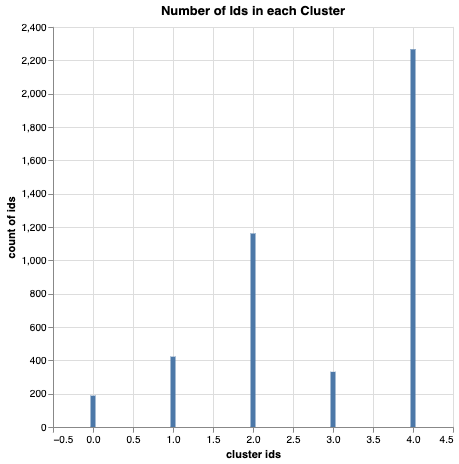

In [25]:
%chart x = td_clusterid_kmeans, y = td_size_kmeans, typex = q, typey = q,
labelx = "cluster ids", labely = "count of ids", type = bar,
title = "Number of Ids in each Cluster", height = 400, width = 400

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The above barchart shows the number of ids in each cluster where cluster_id is 0-4 generated by the TD_Kmeans function.<br>Let us now visualize how the clusters look like. We have used five columns to create clusters namely 'TotalQuantity','TotalPrice','TotalItems','TotalSales','SalesPerItem'.<br> For the visualization in 2d plane i.e with X and Y coordinates we will use two of these column values for our plots.

In [26]:
SELECT * FROM TD_KMeansPredict (
        ON Scaled_Transformed_Customer_ID_Group_VT AS InputTable
        ON KMeans_Model AS ModelTable DIMENSION
        USING
            OutputDistance('true')
            Accumulate('[1:5]')
) AS dt;

,CustomerID,td_clusterid_kmeans,td_distance_kmeans,TotalQuantity,TotalItems,TotalPrice,TotalSales,SalesPerItem
1,12957,0,0.1861478206757987,0.5253562447611064,0.0560368164591229,0.5329341317365269,0.30417984916074264,0.015130672657059908
2,16168,3,0.12905940270979804,0.3906119027661358,0.015159718462371413,0.25100643965644787,0.10803010514087587,0.019620266936850688
3,13349,4,0.006479281586126379,0.04212070410729254,0.004060638873849486,0.04485177888695951,0.0024844621953746624,0.0016091352755077605
4,12910,3,0.17474790871914198,0.3495389773679799,0.012723335138061722,0.11691052225847395,0.04614431813791765,0.009945160564586202
5,14288,4,0.012549056734959034,0.03415758591785415,0.004060638873849486,0.04207190300802816,0.0019427086578951672,0.0012583183928720901
6,14090,4,0.057112629437922335,0.010058675607711651,0,0.09520490877802268,0.0015801838941958608,0.01672159759468308
7,16434,2,0.10388235375538758,0.15423302598491198,0.023551705468327015,0.26791151117790435,0.04633428617072908,0.005436557133472432
8,13500,2,0.017575686548798434,0.11756077116512992,0.01597184623714131,0.18021693933329702,0.02420078807277165,0.004162277753045963
9,16830,4,0.01958726970254825,0.050293378038558254,0.005955603681645912,0.03283679714692852,0.0022130002969937223,0.0009901197840973578
10,14680,1,0.17739778800351802,0.07145850796311819,0.022198159177043854,0.5991839468008066,0.04923547717490039,0.006127601546205688


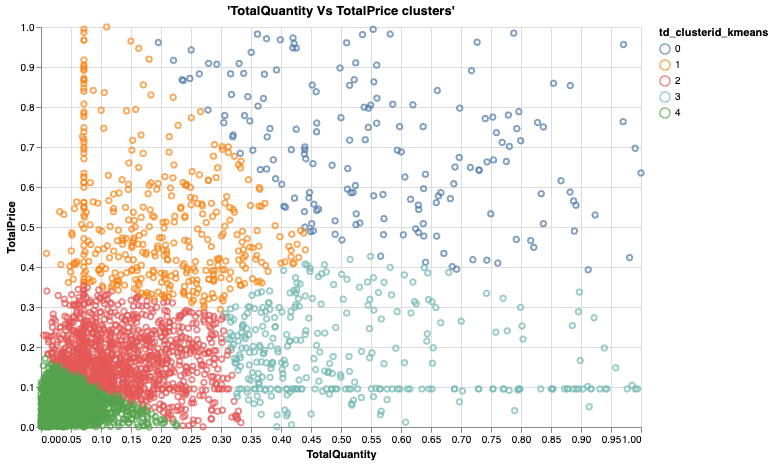

In [27]:
%chart x = TotalQuantity, y = TotalPrice, groupingcol = td_clusterid_kmeans, typegroupingcol = nominal,
mark = point, title = 'TotalQuantity Vs TotalPrice clusters', height = 400, width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> In the above chart we have plotted TotalQuantity Vs TotalPrice to see how the clusters look like in the 2d plane where X axis is TotalQuantity and Y axis is TotalPrice. Note that this is only due to the limitation of visualization on being only in 2 dimensions where as the cluster creation is based on all 5 columns.

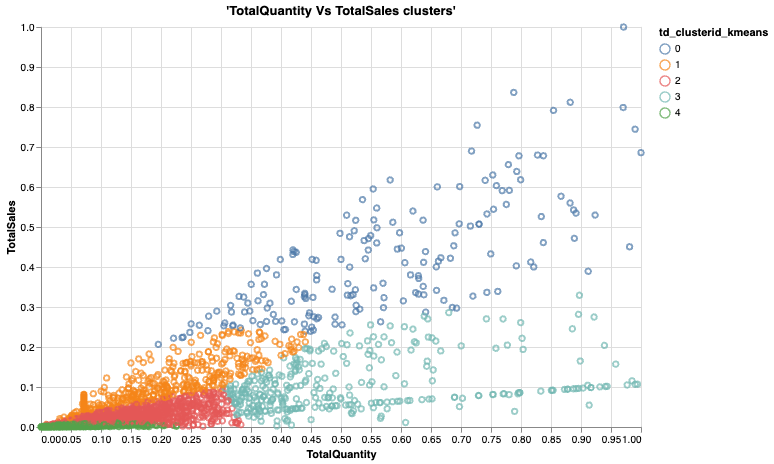

In [28]:
%chart x = TotalQuantity, y = TotalSales, groupingcol = td_clusterid_kmeans, typegroupingcol = nominal,
mark = point, title = 'TotalQuantity Vs TotalSales clusters', height = 400, width = 600

<p style = 'font-size:16px;font-family:Arial;color:#00233C'> In the above chart we have plotted TotalQuantity Vs TotalSales. See how the chart is different from the TotalQuantity Vs TotalPrice chart. You can change the values for x-axis and y-axis to see how the clusters with rest of the columns looks like.

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5. Bulk Transformation</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, the Fit tables created above will be passed to a single <a href = 'https://docs.teradata.com/search/all?query=TD_ColumnTransformer&content-lang=en-US'>TD_ColumnTransformer</a> function.  This is similar to an operational approach, where a single query will prepare new or incoming data for immediate analysis.</p>

<img src = 'images/column_transformer.png' width = '300'>

In [29]:
SELECT  * FROM UK_Retail_Test_V;

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,C542693,15036,ASSORTED COLOURS SILK FAN,-600,2011-01-31 12:36:00.000000,0.65,12908,United Kingdom
2,C541499,84819,DANISH ROSE ROUND SEWING BOX,-1,2011-01-18 15:23:00.000000,4.25,13693,United Kingdom
3,C561590,84968A,SET OF 16 VINTAGE ROSE CUTLERY,-2,2011-07-28 11:16:00.000000,12.75,18268,United Kingdom
4,C540271,M,Manual,-1,2011-06-01 11:51:00.000000,1126,12503,Spain
5,C541498,22776,SWEETHEART CAKESTAND 3 TIER,-1,2011-01-18 15:21:00.000000,9.95,13693,United Kingdom
6,C541499,22325,MOBILE VINTAGE HEARTS,-3,2011-01-18 15:23:00.000000,4.95,13693,United Kingdom
7,561680,84968A,SET OF 16 VINTAGE ROSE CUTLERY,2,2011-07-28 19:13:00.000000,12.75,18268,United Kingdom
8,557092,15036,ASSORTED COLOURS SILK FAN,600,2011-06-16 15:39:00.000000,0.72,12908,United Kingdom
9,C541499,22766,PHOTO FRAME CORNICE,-1,2011-01-18 15:23:00.000000,2.95,13693,United Kingdom
10,542694,15036,ASSORTED COLOURS SILK FAN,600,2011-01-31 12:37:00.000000,0.53,12908,United Kingdom


In [30]:
-- Steps broken up above can be put together into a single query

REPLACE VIEW Scaled_Transformed_Test_V AS (
    
SELECT * FROM TD_ColumnTransformer(
            -- Use our groupby inside the ON clause
            ON (SELECT CustomerID,
                    SUM(quantity) AS TotalQuantity , 
                    SUM(UnitPrice) AS TotalPrice, 
                    COUNT(DISTINCT(StockCode)) AS TotalItems
                FROM UK_Retail_Test_V
                GROUP BY CustomerID
                ) AS InputTable
            
            -- Pass each fit table from above as dimensions
            ON OutlierFit_CS AS OutlierFilterFitTable DIMENSION
            ON ImputeFit_CS AS SimpleImputeFitTable DIMENSION
            ON NonLinearCombineFit_CS_TotalSales AS NonLinearCombineFitTable DIMENSION
            ON NonLinearCombineFit_CS_SalesPerItem AS NonLinearCombineFitTable DIMENSION
            ON ScaleFit_CS as ScaleFitTable DIMENSION
    ) AS dt
)

Success: 7 rows affected

In [31]:
SELECT * FROM Scaled_Transformed_Test_V;

,CustomerID,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem
1,18268,0.07145850796311819,0.01454568106959034,0,0.0015825105018033377,0.016745703411708848
2,17307,0.07145850796311819,0.09520490877802268,0,0.008156920209762426,0.0848626978559787
3,13693,0.07145850796311819,0.01189818023251287,0.0008121277747698972,0.001366716776774995,0.0036102401301112224
4,12908,0.07145850796311819,0.09520490877802268,0.0002707092582566324,0.008156920209762426,0.04241986236899423
5,12503,0.07145850796311819,0.8714794078942247,0,0.07142986179406546,0.7404291748208797


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6. Predict and Evaluate</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Finally, we run the model against new (in this case testing) data using <a href = 'https://docs.teradata.com/search/all?query=TD_KMeansPredict&content-lang=en-US'>TD_KMeansPredict</a>.  The preparation step has been completed in a single query above.  Additionally, we will use an evaluation function <a href = 'https://docs.teradata.com/search/all?query=TD_Silhouette&content-lang=en-US'>TD_Silhouette</a> to analyze how well the new cluster predictions match the original model.</p>

<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Call TD_KMeansPredict</li>
    <li>Inpect the results</li>
    <li>Call TD_Silhouette on the output</li>
    </ol>

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6.1 Call the Prediction Function</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Pass the Input Data, Model Table, and other parameters including columns to accumulate.  Note here we create a new View to assist with Silhouette analysis of the prediction.</p>

In [32]:
REPLACE VIEW KMeans_Output_V AS (
    SELECT * FROM TD_KMeansPredict (
        ON Scaled_Transformed_Test_V AS InputTable
        ON KMeans_Model as ModelTable DIMENSION
        USING
            OutputDistance('true')
            Accumulate('[1:5]')
    ) AS dt
)

Success: 9 rows affected

<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>6.2 Inspect the Results</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Simple SELECT on the output view will show us the results</p>

In [33]:
SELECT * FROM KMeans_Output_V;

,CustomerID,td_clusterid_kmeans,td_distance_kmeans,TotalQuantity,TotalPrice,TotalItems,TotalSales,SalesPerItem
1,18268,4,0.048519332848487265,0.07145850796311819,0.01454568106959034,0,0.0015825105018033377,0.016745703411708848
2,17307,4,0.09755627159520262,0.07145850796311819,0.09520490877802268,0,0.008156920209762426,0.0848626978559787
3,13693,4,0.048620581590771324,0.07145850796311819,0.011898180232512868,0.0008121277747698972,0.0013667167767749948,0.0036102401301112215
4,12908,4,0.06628160867644284,0.07145850796311819,0.09520490877802268,0.0002707092582566324,0.008156920209762426,0.04241986236899423
5,12503,1,0.8360410369582852,0.07145850796311819,0.8714794078942247,0,0.07142986179406546,0.7404291748208797


<hr style="height:1px;border:none;background-color:#00233C;">

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>6.3 Evaluate the Prediction</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><a href = 'https://docs.teradata.com/search/all?query=TD_Silhouette&content-lang=en-US'>TD_Silhouette</a> is a native Vantage function that evaluates the similarity of an object to its cluster (cohesion) compared to other clusters (separation).  The silhouette scores and its definitions are as follows:</p>

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>1: Data is appropriately clustered</li>
    <li>-1: Data is not appropriately clustered</li>
    <li>0: Datum is on the border of two natural clusters</li>
    </ul>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>See the documentation for a full listing of parameters and return values.</p>

In [34]:
SELECT * FROM TD_Silhouette(
    ON KMeans_Output_V AS inputTable
    USING
        IdColumn('CustomerID')
        ClusterIdColumn('td_clusterid_kmeans')
        TargetColumns('[3:7]')
        OutputType('SCORE')
) AS dt;

,silhouette_score
1,0.7435035095255595


# Logistic Regression

In [35]:
SELECT TOP 5 * FROM DEMO_Retail.UK_Retail_Data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1,562377,47566,PARTY BUNTING,2,2011-04-08 15:04:00.000000,4.95,14535,United Kingdom
2,562377,20992,JAZZ HEARTS PURSE NOTEBOOK,6,2011-04-08 15:04:00.000000,0.39,14535,United Kingdom
3,562377,23191,BUNDLE OF 3 RETRO NOTE BOOKS,3,2011-04-08 15:04:00.000000,1.65,14535,United Kingdom
4,562377,23299,FOOD COVER WITH BEADS SET 2,2,2011-04-08 15:04:00.000000,3.75,14535,United Kingdom
5,539005,22834,HAND WARMER BABUSHKA DESIGN,24,2010-12-15 12:47:00.000000,0.85,16638,United Kingdom


In [47]:
SELECT TOP 10 * FROM Customer_ID_Group_V;

,CustomerID,TotalQuantity,TotalPrice,TotalItems
1,12649,574,86.91,30
2,14288,187,60.849999999999994,16
3,16830,264,48.99,23
4,13349,225,64.42,16
5,17614,235,218.66000000000003,97
6,16168,1888,329.17,57
7,14090,72,1.06,1
8,14680,12474,776.3099999999997,83
9,16434,760,350.88,88
10,12957,2531,691.2299999999999,208


In [48]:
SELECT COUNT(*) as cnt_rowse FROM Customer_ID_Group_V;

,cnt_rowse
1,4368


In [51]:
REPLACE VIEW LR_FEATURES_V AS (
    SELECT
        CustomerID,
        CASE WHEN (TotalQuantity IS NULL) OR (TotalQuantity = 0) THEN 1 ELSE 0 END as TotalQuantity_0_NullOr0,
        CASE WHEN (TotalQuantity BETWEEN 1 AND 500) THEN 1 ELSE 0 END as TotalQuantity_1_lt500,
        CASE WHEN (TotalQuantity BETWEEN 501 AND 1000) THEN 1 ELSE 0 END as TotalQuantity_2_lt1000,
        CASE WHEN (TotalQuantity BETWEEN 1001 AND 2000) THEN 1 ELSE 0 END as TotalQuantity_3_lt2000,
        CASE WHEN (TotalQuantity > 2000) THEN 1 ELSE 0 END as TotalQuantity_4_gt2000,
        CASE WHEN (TotalPrice IS NULL) OR (TotalPrice = 0) THEN 1 ELSE 0 END as TotalPrice_0_NullOr0,
        CASE WHEN (TotalPrice BETWEEN 0.01 AND 50) THEN 1 ELSE 0 END as TotalPrice_1_lt50,
        CASE WHEN (TotalPrice BETWEEN 50.01 AND 200) THEN 1 ELSE 0 END as TotalPrice_2_lt200,
        CASE WHEN (TotalPrice BETWEEN 200.01 AND 750) THEN 1 ELSE 0 END as TotalPrice_3_lt750,
        CASE WHEN (TotalPrice > 750) THEN 1 ELSE 0 END as TotalPrice_4_gt750,
        CASE WHEN (TotalItems IS NULL) OR (TotalItems = 0) THEN 1 ELSE 0 END as TotalItems_0_NullOr0,
        CASE WHEN (TotalItems BETWEEN 1 AND 10) THEN 1 ELSE 0 END as TotalItems_1_lt10,
        CASE WHEN (TotalItems BETWEEN 11 AND 30) THEN 1 ELSE 0 END as TotalItems_2_lt30,
        CASE WHEN (TotalItems BETWEEN 31 AND 100) THEN 1 ELSE 0 END as TotalItems_3_lt100,
        CASE WHEN (TotalItems > 100) THEN 1 ELSE 0 END as TotalItems_4_gt100
    FROM
        Customer_ID_Group_V
    )
    

Success: 12 rows affected

In [52]:
SELECT TOP 10 * FROM LR_FEATURES_V

,CustomerID,TotalQuantity_0_NullOr0,TotalQuantity_1_lt500,TotalQuantity_2_lt1000,TotalQuantity_3_lt2000,TotalQuantity_4_gt2000,TotalPrice_0_NullOr0,TotalPrice_1_lt50,TotalPrice_2_lt200,TotalPrice_3_lt750,TotalPrice_4_gt750,TotalItems_0_NullOr0,TotalItems_1_lt10,TotalItems_2_lt30,TotalItems_3_lt100,TotalItems_4_gt100
1,12649,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,16434,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,17614,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
4,12957,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
5,16830,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
6,16168,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
7,14090,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
8,14680,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
9,14288,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
10,13349,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [56]:
-- get most sold products
WITH total_customers AS (
    SELECT COUNT(DISTINCT CustomerID) AS total_cust
    FROM DEMO_Retail.UK_Retail_Data
),
top_products AS (
    SELECT Description, COUNT(DISTINCT CustomerID) AS num_customers
    FROM DEMO_Retail.UK_Retail_Data
    GROUP BY Description

    QUALIFY ROW_NUMBER() OVER (ORDER BY num_customers DESC) <= 5
)
SELECT tp.Description, tp.num_customers, (tp.num_customers / tc.total_cust) * 100 AS percentage
FROM top_products tp, total_customers tc;


,Description,num_customers,percentage
1,REGENCY CAKESTAND 3 TIER,888,0
2,WHITE HANGING HEART T-LIGHT HOLDER,859,0
3,PARTY BUNTING,709,0
4,ASSORTED COLOUR BIRD ORNAMENT,680,0
5,SET OF 3 CAKE TINS PANTRY DESIGN,641,0


## Who will buy "ASSORTED COLOUR BIRD ORNAMENT" ?

In [67]:
REPLACE VIEW LR_Target_V AS (
SELECT
    CustomerID,
    LEAST(buys_birdornament,1) as buys_birdornament
FROM(
    
SELECT CustomerID,
       SUM(CASE WHEN Description = 'ASSORTED COLOUR BIRD ORNAMENT' THEN 1 ELSE 0 END) AS buys_birdornament
FROM DEMO_Retail.UK_Retail_Data
GROUP BY CustomerID) t);

Success: 3 rows affected

In [68]:
SELECT TOP 10 * FROM LR_Target_V

,CustomerID,buys_birdornament
1,12649,0
2,14090,0
3,14680,0
4,13349,0
5,17614,0
6,12957,0
7,14288,0
8,16830,0
9,16434,0
10,16168,0


In [70]:
REPLACE VIEW LR_ADS_V AS(
SELECT f.*, t.buys_birdornament
FROM
    LR_FEATURES_V f, LR_Target_V t
WHERE f.CustomerId = t.CustomerId)

Success: 0 rows affected

In [71]:
SELECT TOP 20 * FROM LR_ADS_V

,CustomerID,TotalQuantity_0_NullOr0,TotalQuantity_1_lt500,TotalQuantity_2_lt1000,TotalQuantity_3_lt2000,TotalQuantity_4_gt2000,TotalPrice_0_NullOr0,TotalPrice_1_lt50,TotalPrice_2_lt200,TotalPrice_3_lt750,TotalPrice_4_gt750,TotalItems_0_NullOr0,TotalItems_1_lt10,TotalItems_2_lt30,TotalItems_3_lt100,TotalItems_4_gt100,buys_birdornament
1,13403,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,14461,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1
3,13824,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
4,14090,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
5,12602,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
6,16252,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
7,15464,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1
8,14764,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
9,14288,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0
10,12451,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


# Univariate Profile

In [76]:
SELECT 
    TotalItems_0_NullOr0, TotalItems_1_lt10, TotalItems_2_lt30, TotalItems_3_lt100, TotalItems_4_gt100, 
    buys_birdornament,
    COUNT(*) AS n_rows
FROM
    LR_ADS_V
GROUP BY GROUPING SETS 
    ((TotalItems_0_NullOr0,buys_birdornament), 
    ( TotalItems_1_lt10,buys_birdornament), 
    ( TotalItems_2_lt30,buys_birdornament), 
    ( TotalItems_3_lt100,buys_birdornament), 
    ( TotalItems_4_gt100,buys_birdornament)) 
ORDER BY 1,2,3,4,5,6 ASC


,TotalItems_0_NullOr0,TotalItems_1_lt10,TotalItems_2_lt30,TotalItems_3_lt100,TotalItems_4_gt100,buys_birdornament,n_rows
1,,,,,0,0,3160
2,,,,,0,1,435
3,,,,,1,0,528
4,,,,,1,1,244
5,,,,0,,0,2382
6,,,,0,,1,380
7,,,,1,,0,1306
8,,,,1,,1,299
9,,,0,,,0,2544
10,,,0,,,1,569


## logistic Regression Model

In [78]:
CREATE VOLATILE TABLE LR_ADS_T AS 
(SELECT * FROM LR_ADS_V) WITH DATA PRIMARY INDEX (CustomerId)  ON COMMIT PRESERVE ROWS

Success: 0 rows affected

In [80]:
SELECT TOP 10 * FROM LR_ADS_T

,CustomerID,TotalQuantity_0_NullOr0,TotalQuantity_1_lt500,TotalQuantity_2_lt1000,TotalQuantity_3_lt2000,TotalQuantity_4_gt2000,TotalPrice_0_NullOr0,TotalPrice_1_lt50,TotalPrice_2_lt200,TotalPrice_3_lt750,TotalPrice_4_gt750,TotalItems_0_NullOr0,TotalItems_1_lt10,TotalItems_2_lt30,TotalItems_3_lt100,TotalItems_4_gt100,buys_birdornament
1,15759,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,14108,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,16836,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,17015,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1
5,18110,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6,12354,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
7,17324,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
8,16527,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
9,15122,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
10,14878,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0


In [85]:
CREATE VOLATILE TABLE LR_MODEL_T AS (
SELECT * FROM TD_GLM (
  ON LR_ADS_T AS InputTable  
  USING
  InputColumns ('[1:15]')
  ResponseColumn('buys_birdornament')
  Family ('Binomial') 
    ) as dt) WITH DATA ON COMMIT PRESERVE ROWS

Success: 0 rows affected

In [86]:
SELECT * FROM LR_MODEL_T

,attribute,predictor,estimate,value
1,0,(Intercept) ,-1.26417609435655,
2,1,TotalQuantity_0_NullOr0,0,
3,2,TotalQuantity_1_lt500,-0.4039003765111466,
4,3,TotalQuantity_2_lt1000,0,
5,4,TotalQuantity_3_lt2000,0,
6,5,TotalQuantity_4_gt2000,0.10945378875819292,
7,6,TotalPrice_0_NullOr0,0,
8,7,TotalPrice_1_lt50,-0.4236717006533785,
9,8,TotalPrice_2_lt200,-0.20944513222510752,
10,9,TotalPrice_3_lt750,0.002540919542369051,


In [92]:
REPLACE VIEW LR_PREDICTIONS_V AS (
SELECT * FROM TD_GLMPredict (
  ON LR_ADS_T AS  InputTable 
  ON LR_MODEL_T AS  ModelTable DIMENSION
  USING
  IDColumn ('CustomerId')
  Accumulate('buys_birdornament')
  OutputProb ('true')
  Responses ('1')
  Family ('Binomial') 
) as dt)

Success: 0 rows affected

In [93]:
SELECT TOP 10  * FROM LR_PREDICTIONS_V

,CustomerID,prediction,prob_1,buys_birdornament
1,15759,0,0.07804852217308789,0
2,12620,0,0.18639282923443698,0
3,15263,0,0.08904978484369437,0
4,12517,0,0.25413550181322947,0
5,13116,0,0.10802589980027119,0
6,15374,0,0.07804852217308789,0
7,13013,0,0.2754344507904431,1
8,15618,0,0.1326738067684947,1
9,12872,0,0.1326738067684947,1
10,15019,0,0.1326738067684947,0


## evaluation

In [98]:
SELECT 
    buys_birdornament, 
    prediction,
    COUNT(buys_birdornament) as cnt_rows, 
    AVG(prob_1) as avg_prob,
    STDDEV_POP(prob_1) as std_prob
FROM 
    LR_PREDICTIONS_V
GROUP BY
    buys_birdornament, prediction

,buys_birdornament,prediction,cnt_rows,avg_prob,std_prob
1,1,0,679,0.2006601452583721,0.07021321285964875
2,0,0,3688,0.15109204398631254,0.06536437316476812


In [102]:
SELECT * FROM
TD_ClassificationEvaluator (
   ON LR_PREDICTIONS_V AS InputTable
   USING
   ObservationColumn('buys_birdornament')
   PredictionColumn('prediction')

      NumLabels (2) --|  Labels ('label1'[,...])

) dt

,SeqNum,Prediction,Mapping,CLASS_1,CLASS_2,Precision,Recall,F1,Support
1,0,0,CLASS_1,3688,679,0.8445156858255095,1,0.9157045313469894,3688
2,1,1,CLASS_2,0,0,0,0,0,679


In [105]:
SELECT * FROM TD_ROC(
 ON LR_PREDICTIONS_V AS InputTable
 OUT VOLATILE TABLE OutputTable(LR_ROC_T)
 USING
 ProbabilityColumn ('prob_1')
 ObservationColumn ('buys_birdornament')
) dt

Success: 0 rows affected

,AUC,GINI
1,0.7000645328238863,0.4001290656477725


In [106]:
SEL * FROM LR_ROC_T

,threshold_value,tpr,fpr
1,0,1,1
2,0.02040816326530612,1,1
3,0.04081632653061224,1,1
4,0.061224489795918366,1,1
5,0.08163265306122448,0.9646539027982327,0.8549349240780911
6,0.1020408163265306,0.9234167893961709,0.7532537960954447
7,0.12244897959183673,0.8262150220913107,0.55558568329718
8,0.14285714285714285,0.7128129602356407,0.4200108459869848
9,0.16326530612244897,0.625920471281296,0.34137744034707157
10,0.18367346938775508,0.6229749631811488,0.3332429501084599


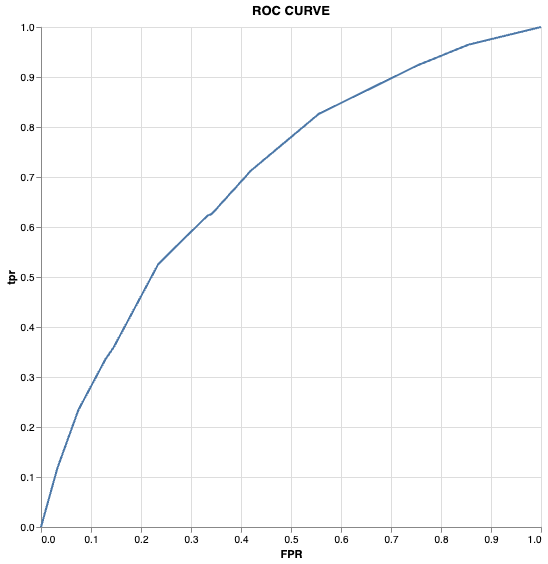

In [107]:
%chart title = ROC CURVE, x = fpr, labelx = FPR, y = tpr, mark = line, height = 500, width = 500

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>7. Clean up</b></p>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Worktables</b></p>

In [ ]:
DROP VIEW UK_Retail_Test_V;

In [ ]:
DROP VIEW Customer_ID_Group_V;

In [ ]:
DROP TABLE KMeans_Model;

In [ ]:
DROP VIEW Scaled_Transformed_Test_V;

In [ ]:
DROP VIEW KMeans_Output_V;

<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b>Database and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

call remove_data('DEMO_Retail');    -- takes about 5 seconds, optional if you want to use the data later

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'> <b> 8. Conclusion </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In this notebook we have seen some of the Teradata Vantage Clearscape's new inDb functions and how we can create k clustering model from the transformed data.</p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Reference Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
        <li>Teradata Analytic Function Reference:
        <a href = 'https://docs.teradata.com/r/Teradata-VantageCloud-Lake/Analyzing-Your-Data/Analytics-Database-Analytic-Functions/Analytics-Database-Analytic-Functions-Overview'>
        https://docs.teradata.com/r/Teradata-VantageCloud-Lake/Analyzing-Your-Data/Analytics-Database-Analytic-Functions/Analytics-Database-Analytic-Functions-Overview</a></li>
  
</ul>

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023. All Rights Reserved
        </div>
    </div>
</footer>